<a href="https://colab.research.google.com/github/KKOUWE/NumMet-Network-Design-Physarum-polycephalum-Ph/blob/main/Gravity_Based_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Traffic Flows (F_ij) between nodes (normalized):
From A to B: 0.6455
From A to C: 0.7454
From A to D: 0.7071
From B to C: 0.9129
From B to D: 0.8660
From C to D: 1.0000


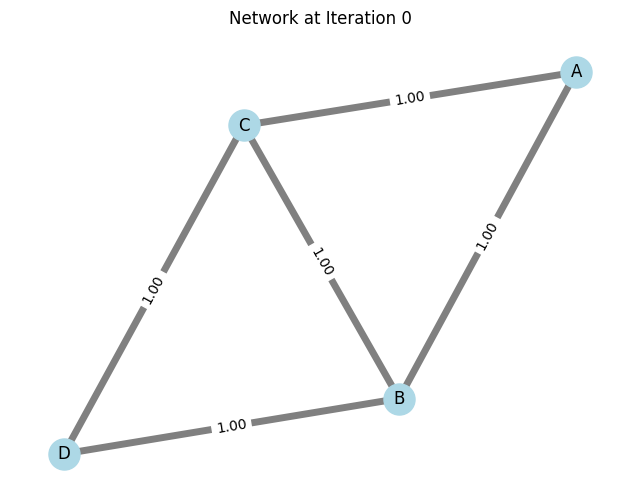

Iteration 1, max_change: 0.09332095007419405
Iteration 2, max_change: 0.08402519952770038
Iteration 3, max_change: 0.07566235469883098
Iteration 4, max_change: 0.06813935600930332
Iteration 5, max_change: 0.0613724512118462
Iteration 6, max_change: 0.05528626148796889
Iteration 7, max_change: 0.049812940397598426
Iteration 8, max_change: 0.0448914164061161
Iteration 9, max_change: 0.04046671066877133
Iteration 10, max_change: 0.036489322616302944
Iteration 11, max_change: 0.03291467666677561
Iteration 12, max_change: 0.02970262409356811
Iteration 13, max_change: 0.026816994713141584
Iteration 14, max_change: 0.024225193622540664
Iteration 15, max_change: 0.02189783871855122
Iteration 16, max_change: 0.019808435170696498
Iteration 17, max_change: 0.0179330834015346
Iteration 18, max_change: 0.016250217453409987
Iteration 19, max_change: 0.01474037089540256
Iteration 20, max_change: 0.013385967653593234
Iteration 21, max_change: 0.012171135339285488
Iteration 22, max_change: 0.0110815388

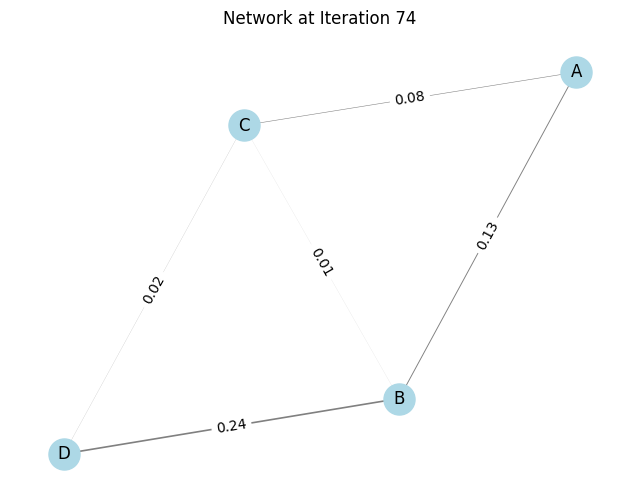


Final Conductivities (D_ij) on edges:
Edge A-B: D_ij = 0.1341
Edge A-C: D_ij = 0.0764
Edge B-C: D_ij = 0.0095
Edge B-D: D_ij = 0.2383
Edge C-D: D_ij = 0.0197


In [8]:
# Import necessary libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Define the Network
# ---------------------------

# Create an undirected graph
G = nx.Graph()

# Add nodes with their GDPs (in millions)
G.add_node('A', GDP=100)
G.add_node('B', GDP=150)
G.add_node('C', GDP=200)
G.add_node('D', GDP=180)  # Node 'D'

# Add edges with their lengths (in km)
G.add_edge('A', 'B', length=10)
G.add_edge('B', 'C', length=15)
G.add_edge('A', 'C', length=20)
G.add_edge('B', 'D', length=12)
G.add_edge('C', 'D', length=8)

# ---------------------------
# Step 2: Gravity Model
# ---------------------------

# Parameters for the gravity model
alpha1 = 0.5  # Exponent for GDP of origin city
alpha2 = 0.5  # Exponent for GDP of destination city
alpha3 = 0    # Exponent for distance (set to 0 as per the assumption)
r = 1         # Scaling constant

# Function to calculate traffic flow using the gravity model (unidirectional)
def calculate_traffic_flow(G, r, alpha1, alpha2, alpha3):
    traffic_flows = {}  # Dictionary to store traffic flows F_ij
    nodes = list(G.nodes())

    for i in nodes:
        for j in nodes:
            if i != j and i < j:  # Only consider one direction (i < j)
                GDP_i = G.nodes[i]['GDP']
                GDP_j = G.nodes[j]['GDP']
                # Since alpha3 = 0, distance term becomes 1
                distance = 1
                # Compute F_ij
                F_ij = r * ((GDP_i ** alpha1) * (GDP_j ** alpha2)) / (distance ** alpha3)
                traffic_flows[(i, j)] = F_ij
    return traffic_flows

# Calculate traffic flows
traffic_flows = calculate_traffic_flow(G, r, alpha1, alpha2, alpha3)

# Normalize traffic flows to prevent numerical instability
max_flow = max(traffic_flows.values())
traffic_flows = {k: v / max_flow for k, v in traffic_flows.items()}

# Display the calculated traffic flows
print("Traffic Flows (F_ij) between nodes (normalized):")
for key, value in traffic_flows.items():
    print(f"From {key[0]} to {key[1]}: {value:.4f}")

# ---------------------------
# Step 3: Physarum Algorithm
# ---------------------------

# Initialize conductivities D_ij for each edge
for u, v, data in G.edges(data=True):
    data['D_ij'] = 1.0  # Initial conductivity
    data['Q_ij'] = 0.0  # Initialize flux
    data['L_ij'] = data['length']  # Length of the edge

# Parameters for the Physarum model
gamma = 10.0       # Increased decay rate to prevent conductivities from growing indefinitely
delta_t = 0.01     # Decreased time step to reduce changes per iteration
max_iterations = 1000  # Increased maximum number of iterations
tolerance = 1e-3   # Increased tolerance for convergence

# Function to assemble the conductance matrix and RHS vector
def assemble_conductance_matrix(G, F_ij):
    nodes = list(G.nodes())
    n = len(nodes)
    node_indices = {node: i for i, node in enumerate(nodes)}
    A = np.zeros((n, n))
    b = np.zeros(n)

    # Build the conductance matrix A
    for u, v, data in G.edges(data=True):
        i = node_indices[u]
        j = node_indices[v]
        D_ij = data['D_ij']
        L_ij = data['L_ij']
        conductance = D_ij / L_ij

        # Update the matrix A
        A[i, i] += conductance
        A[j, j] += conductance
        A[i, j] -= conductance
        A[j, i] -= conductance

    # Apply traffic flows F_ij as sources and sinks
    for (origin, dest), flow in F_ij.items():
        i = node_indices[origin]
        j = node_indices[dest]
        b[i] -= flow  # Source node
        b[j] += flow  # Sink node

    # Fix the pressure at one node to zero (e.g., node 'D')
    ref_node = 'D'
    ref_index = node_indices[ref_node]
    A[ref_index, :] = 0
    A[ref_index, ref_index] = 1
    b[ref_index] = 0

    return A, b, node_indices

# Function to calculate fluxes Q_ij
def calculate_fluxes(G, pressures, node_indices):
    for u, v, data in G.edges(data=True):
        i = node_indices[u]
        j = node_indices[v]
        D_ij = data['D_ij']
        L_ij = data['L_ij']
        p_i = pressures[i]
        p_j = pressures[j]
        # Calculate flux Q_ij
        Q_ij = D_ij * (p_i - p_j) / L_ij
        data['Q_ij'] = Q_ij

# Function to update conductivities D_ij
def update_conductivities(G):
    max_change = 0.0  # To check convergence
    D_ij_max = 10.0   # Maximum allowable conductivity
    for u, v, data in G.edges(data=True):
        D_ij_old = data['D_ij']
        Q_ij = data['Q_ij']
        # Update D_ij using Equation (7)
        D_ij_new = D_ij_old + delta_t * (abs(Q_ij) - gamma * D_ij_old)
        # Ensure D_ij_new remains within bounds
        D_ij_new = min(max(D_ij_new, 0.0), D_ij_max)
        data['D_ij'] = D_ij_new
        # Calculate the maximum change in D_ij
        change = abs(D_ij_new - D_ij_old)
        if change > max_change:
            max_change = change
    return max_change

# Function to visualize the network at a given iteration
def visualize_network(G, iteration):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  # Fixed layout for consistency
    edge_widths = [data['D_ij'] * 5 for _, _, data in G.edges(data=True)]  # Scale for visualization

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='grey')
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    # Edge labels for conductivities
    edge_labels = {(u, v): f"{data['D_ij']:.2f}" for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    # Title with iteration number
    plt.title(f"Network at Iteration {iteration}")
    plt.axis('off')
    plt.show()

# Main loop for the Physarum algorithm

# Visualize the network at the beginning
visualize_network(G, iteration=0)

converged = False
for iteration in range(1, max_iterations + 1):
    # Assemble the conductance matrix and RHS vector
    A, b, node_indices = assemble_conductance_matrix(G, traffic_flows)
    # Solve for pressures p_i
    try:
        pressures = np.linalg.solve(A, b)
    except np.linalg.LinAlgError as e:
        print(f"Error solving linear system at iteration {iteration}: {e}")
        break
    # Calculate fluxes Q_ij
    calculate_fluxes(G, pressures, node_indices)
    # Update conductivities D_ij
    max_change = update_conductivities(G)
    print(f"Iteration {iteration}, max_change: {max_change}")
    # Check for convergence
    if max_change < tolerance:
        print(f"Converged after {iteration} iterations.")
        converged = True
        break

if not converged:
    print("Reached maximum iterations without full convergence.")

# Visualize the network at the end
visualize_network(G, iteration=iteration)

# ---------------------------
# Step 4: Display Results
# ---------------------------

# Print final conductivities
print("\nFinal Conductivities (D_ij) on edges:")
for u, v, data in G.edges(data=True):
    print(f"Edge {u}-{v}: D_ij = {data['D_ij']:.4f}")
